In [49]:
# instalar dependencias
!pip install pandas
!pip install jax
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install scikit-learn
!pip install matplotlib


/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


# KNN

In [50]:
import pandas as pd
import jax.numpy as jnp
import numpy as np

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

In [51]:
#separa treino e teste
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1) # features
y = data['target'] # target

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, random_state=42)

# transforma em array
print(X_train_original)
X_train = jnp.array(X_train_original)
print(X_train[:, 17]) # imprime a primeira coluna do conjunto de treino
X_test = jnp.array(X_test_original)
y_train = jnp.array(y_train_original)
y_test = jnp.array(y_test_original)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
158    14.34        1.68  2.70               25.0       98.0           2.80   
137    12.53        5.51  2.64               25.0       96.0           1.79   
98     12.37        1.07  2.10               18.5       88.0           3.52   
159    13.48        1.67  2.64               22.5       89.0           2.60   
38     13.07        1.50  2.10               15.5       98.0           2.40   
..       ...         ...   ...                ...        ...            ...   
71     13.86        1.51  2.67               25.0       86.0           2.95   
106    12.25        1.73  2.12               19.0       80.0           1.65   
14     14.38        1.87  2.38               12.0      102.0           3.30   
92     12.69        1.53  2.26               20.7       80.0           1.38   
102    12.34        2.45  2.46               21.0       98.0           2.56   

     flavanoids  nonflavanoid_phenols  proanthocyan

In [52]:
def native_knn(X_train, y_train, X_test, k):
    # funcao que utiliza o knn nativo como comparativo
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

def evaluate(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred)
    

def knn(X_train, y_train, X_test, k, metric):
    # Para reazliar o knn, vamos 
    distances = jnp.array([[metric(x, x_train) for x_train in X_train] for x in X_test])
    min_distances = jnp.argsort(distances, axis=1)[:, :k] 
    palpites = jnp.array(y_train[min_distances], dtype=int)
    moda = jnp.array([jnp.bincount(palpite).argmax() for palpite in palpites])
    return moda

class Metrica():

    def __init__(self, produto_interno= jnp.dot):
        self.produto_interno = produto_interno


    def __call__(self, x, y):
        """
        Uma metrica de distancia calcula a distancia, um valor escalar, entre dois vetores dado
        um produto interno entre vetores. Um exemplo de produto interno é o dot product, utilizado como
        padrão nessa função.

        O produto interno será aplicado em x-y e x-y obtendo assim o quadrado da métrica. É então retornado
        a raiz quadrada do resultado.

        """
        return jnp.sqrt(self.produto_interno(x-y, x-y))

def produto_interno_crescente(x, y):
    # produz um vetor [1,2,3,4,5,6,7,8,9,...]
    importancia = jnp.arange(1, len(x)+1)
    return jnp.sum(importancia*x*y)


def produto_interno_decrescente(x, y):
    # produz um vetor [...,10,9,8,7,6,5,4,3,2,1]
    importancia = jnp.arange(len(x), 0, -1)
    return jnp.sum(importancia*x*y)

def produto_interno_apenas_impar(x, y):
    # produz um vetor [1,0,1,0,1,0,1,0,...]
    importancia = jnp.arange(1,len(x)+1) % 2
    return jnp.sum(importancia*x*y)


def produto_interno_apenas_primeiro(x, y):
    return x[0] * y[0]



In [53]:
manhattan = lambda x, y: jnp.sum(jnp.abs(x - y))
euclidean = lambda x, y: jnp.sqrt(jnp.sum((x - y) ** 2))




gk = knn(X_train, y_train, X_test, 3, euclidean)
print("acuracia do knn proprio",evaluate(y_test, gk))
knn_nativo = native_knn(X_train, y_train, X_test, 3)
print("acuracia do knn nativo como comparação de corretude",evaluate(y_test, knn_nativo))
gkm = knn(X_train, y_train, X_test, 3, manhattan)
print("acuracia do knn proprio com distância de manhattan",evaluate(y_test, gkm))




comum_knn = knn(X_train, y_train, X_test, 3, Metrica(lambda x, y: jnp.sum(x * y)))
print("acuracia do knn com metrica baseado em um produto interno comum",evaluate(y_test, comum_knn))
crescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_crescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores",evaluate(y_test, crescente_knn))
decrescente_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_decrescente))
print("acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores",evaluate(y_test, decrescente_knn))
impar_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_impar))
print("acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores",evaluate(y_test, impar_knn))
primeiro_knn = knn(X_train, y_train, X_test, 3, Metrica(produto_interno_apenas_primeiro))
print("acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor",evaluate(y_test, primeiro_knn))

acuracia do knn proprio 0.8055555555555556
acuracia do knn nativo como comparação de corretude 0.8055555555555556
acuracia do knn proprio com distância de manhattan 0.8333333333333334
acuracia do knn com metrica baseado em um produto interno comum 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os últimos valores dos vetores 0.8055555555555556
acuracia do knn com metrica baseado em um produto interno que valoriza mais os primeiros valores dos vetores 0.7222222222222222
acuracia do knn com metrica baseado em um produto interno que apenas considera indices impares dos vetores 0.7777777777777778
acuracia do knn com metrica baseado em um produto interno que valoriza apenas a primeira componente do vetor 0.6944444444444444


# PCA e SVD

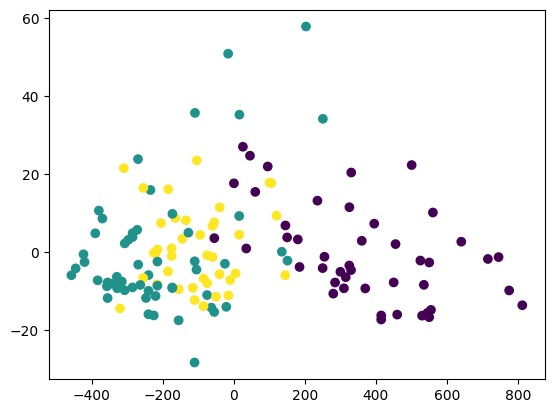

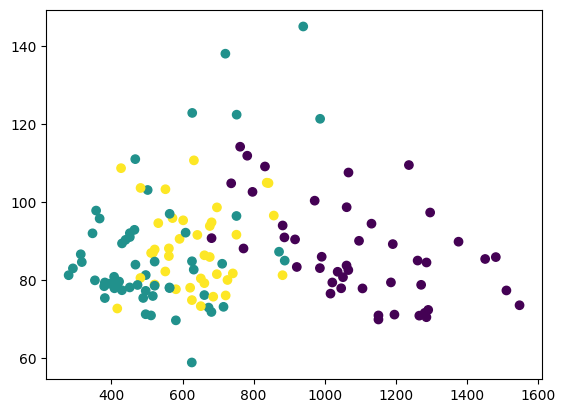

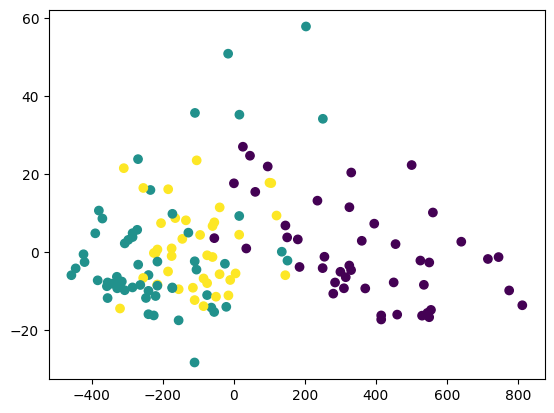

In [54]:
from jax.scipy.linalg import svd
import matplotlib.pyplot as plt

def pca_sem_svd(data, num_components):
    # Calcula a matriz de covariância
    cov_matrix = jnp.cov(data, rowvar=False)
    # Calcula os autovalores e autovetores
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)
    # Ordena os autovetores de acordo com os autovalores
    idx = jnp.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    # Seleciona os num_components autovetores
    eigenvectors = eigenvectors[:, :num_components]
    # Transforma os dados originais
    return jnp.dot(data, eigenvectors)



def pca(data, num_components):
    # Centralizar os dados
    data_centered = data - jnp.mean(data, axis=0)

    # Calcular a matriz de covariância
    cov_matrix = jnp.dot(data_centered.T, data_centered) / (data_centered.shape[0] - 1)

    # Calcular a SVD da matriz de covariância
    U, S, VT = jnp.linalg.svd(cov_matrix)

    # Selecionar os primeiros componentes principais
    principal_components = VT[:num_components]


    # Projetar os dados nos componentes principais
    novo_dado = jnp.dot(data_centered, principal_components.T)

    return novo_dado

    


pca_vec = pca(X_train, 2)


plt.scatter(pca_vec[:, 0], pca_vec[:, 1], c=y_train_original)
plt.show()

pca_vec_sem_svd = pca_sem_svd(X_train, 2)

plt.scatter(pca_vec_sem_svd[:, 0], pca_vec_sem_svd[:, 1], c=y_train_original)
plt.show()

from sklearn.decomposition import PCA

pca_calculer = PCA(n_components=2)
pca_calculer.fit(X_train_original)
X_train_pca = pca_calculer.transform(X_train_original)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_original)
plt.show()



In [55]:
def base_ortonormal(matrix):
    # Calcular a SVD
    U, sigma, VT = svd(matrix)
    return VT

ortNor = base_ortonormal(X_train)

produto = jnp.dot(ortNor, ortNor.T)

if jnp.allclose(produto, jnp.eye(produto.shape[1]), atol=1e-6):
    # se a norma é 1
    if jnp.allclose(jnp.linalg.norm(produto, axis=0), 1):
        print("A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I")
    else:
        print("A matriz é apenas ortogonal, pois o módulo de suas colunas não é 1, mas A^T*A = I")
else:
    print("A matriz não é ortonormal nem ortogonal, pois A^T*A != I")

# se o det é 0
if jnp.abs(jnp.linalg.det(ortNor)) < 1e-6:
    print("A matriz é linearmente dependente, portanto não é uma base")
else:
    print("A matriz é uma base, pois é linearmente independente")

print("A base tem shape ", ortNor.shape, " e a matriz original tem shape ", X_train.shape)

A matriz é ortonormal, pois o módulo de suas colunas é 1 e A^T*A = I
A matriz é uma base, pois é linearmente independente
A base tem shape  (13, 13)  e a matriz original tem shape  (142, 13)


In [56]:
def obter_matriz_projecao(base):
    return jnp.dot(base, base.T)

def verificar_matriz_projecao(matriz_projecao):
    if jnp.allclose(matriz_projecao, matriz_projecao @ matriz_projecao, atol=1e-6):
        print("A matriz pode ser uma matriz de projeção, pois P^2 = P")
    else:
        print("A matriz não pode ser uma matriz de projeção, pois P^2 != P")
        return False
    if jnp.allclose(matriz_projecao, matriz_projecao.T, atol=1e-6):
        print("A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica")
        return True
    return False

matriz_projecao = obter_matriz_projecao(ortNor)
_ = verificar_matriz_projecao(matriz_projecao)

A matriz pode ser uma matriz de projeção, pois P^2 = P
A matriz é uma matriz de projeção, pois P^T = P, ou seja, é simétrica


# KNN com PCA

(178, 13)
(142, 2) (36, 2)
[0. 1. 2.]


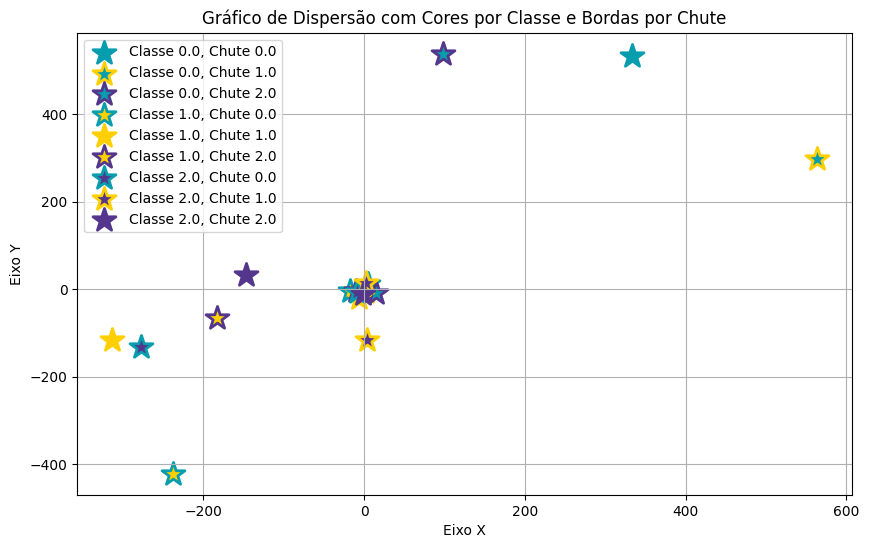

In [237]:
concatenado = jnp.concatenate((X_train, X_test), axis=0)
print(concatenado.shape)

# calcula o pca
pca_vec_conc = pca(concatenado, 2)

pca_train, pca_test = pca_vec_conc[:X_train.shape[0]], pca_vec_conc[X_train.shape[0]:]
print(pca_train.shape, pca_test.shape)

"""
cores = {0:'#069DAE', 1: '#FFCF00', 2:'#54378D'}
# deixa o plot maior
plt.figure(figsize=(10, 7))
#plota pca_train com bolinhas e suas classes
plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train_original)
# plota pca_test com * e suas classes, alem de borda e tamanho 10
plt.sca
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y_test_original, marker='*', edgecolors="black", linewidth=1, s=300)
plt.show()
# printa as cores usadas
"""



cores = {0.0:'#069DAE', 1.0: '#FFCF00', 2.0:'#54378D'}
# cores = {0: 'red', 1: 'green', 2: 'blue'}

np.random.seed(42)
chutes = np.random.randint(0, 3, y_test_original.shape[0]).astype(float)
print(np.unique(chutes))

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
#plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train_original)
for c in np.unique(y_test_original):

    for ch in np.unique(chutes):

        mask = jnp.array((y_test_original == c) & (chutes == ch))
        # se mascara vazia pula
        if jnp.sum(mask) == 0:
            continue
        plt.scatter(pca_test[mask][0], pca_test[mask][1], 
                    color=cores[c], 
                    edgecolor=cores[ch], 
                    linewidth=2, 
                    label=f'Classe {c}, Chute {ch}', 
                    alpha=1.0, marker='*', s=300)

plt.title('Gráfico de Dispersão com Cores por Classe e Bordas por Chute')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.legend()
plt.grid()
plt.show()


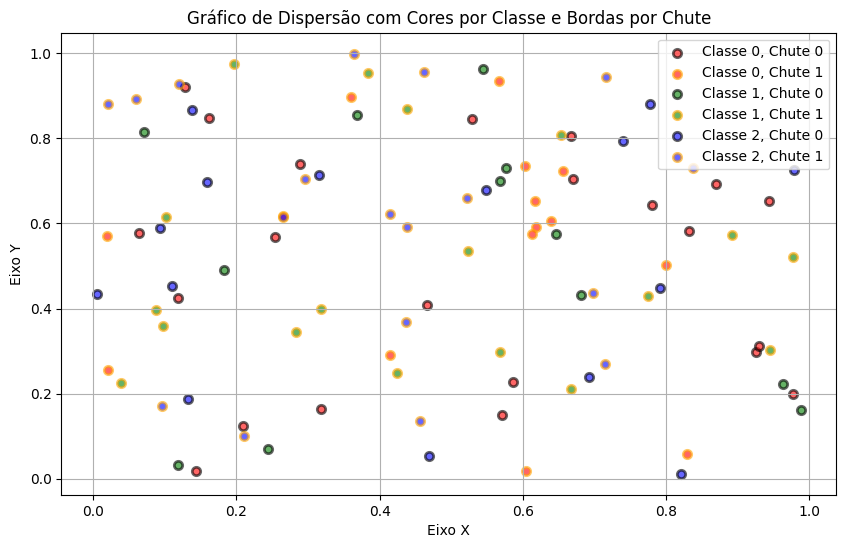

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Gerar alguns dados de exemplo
np.random.seed(0)
num_points = 100
x = np.random.rand(num_points)
y = np.random.rand(num_points)

# Definindo classes (por exemplo, 3 classes)
classes = np.random.randint(0, 3, num_points)

# Definindo chutes (por exemplo, 2 chutes)
chutes = np.random.randint(0, 2, num_points)

# Criar um dicionário de cores para as classes
colors = {0: 'red', 1: 'green', 2: 'blue'}

# Criar um dicionário de cores para as bordas dos chutes
border_colors = {0: 'black', 1: 'orange'}

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
for c in np.unique(classes):
    for ch in np.unique(chutes):
        mask = (classes == c) & (chutes == ch)
        plt.scatter(x[mask], y[mask], 
                    color=colors[c], 
                    edgecolor=border_colors[ch], 
                    linewidth=2, 
                    label=f'Classe {c}, Chute {ch}', 
                    alpha=0.6)

plt.title('Gráfico de Dispersão com Cores por Classe e Bordas por Chute')
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
plt.legend()
plt.grid()
plt.show()
